In [1]:
import xarray as xr
import numpy as np
import pyproj as proj
import random
from datetime import datetime, timedelta
import matplotlib.cm as cm
from seawater.eos80 import ptmp, pden, dens0
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.crs as ccrs
import cartopy as cr
import matplotlib.pyplot as plt
import matplotlib.colors as col
import matplotlib as mpl
import time
import cartopy.crs as ccrs
import os
import copy as cp
#test 

# Load Data

In [2]:
path_clusters = '/storage/mathilde/MainProject/1_ExternalProcesses/LagrangianTracking/Clustering/Last_Version/config_k-cosine-w-cos_30noresampnoresamp_goodw/ClassifiedData/'
path_figs = '/storage/mathilde/MainProject/1_ExternalProcesses/LagrangianTracking/Clustering/Last_Version/config_k-cosine-w-cos_30noresampnoresamp_goodw/Figs/'

Dates_all = []; n_labels_all = [];
for yr in range(1993,2014):#2017
    print('Year', yr)
    labels_data = np.load(path_clusters+'labels_data_'+str(yr)+'.npy', allow_pickle = True)
    time_data = np.load(path_clusters+'time_data_'+str(yr)+'.npy', allow_pickle = True)
    Date_data = np.unique(time_data)
    Dates_all.extend(Date_data)
    n_labels = np.zeros((len(Date_data), 30))
    for i in range(len(Date_data)):
        d0 = np.where(Date_data[i] ==time_data)[0]
        for di in d0:
            n_labels[i,labels_data[di]] +=1
    n_labels_all.extend(n_labels)
n_labels_all = np.array(n_labels_all)

Year 1993
Year 1994
Year 1995
Year 1996
Year 1997
Year 1998
Year 1999
Year 2000
Year 2001
Year 2002
Year 2003
Year 2004
Year 2005
Year 2006
Year 2007
Year 2008
Year 2009
Year 2010
Year 2011
Year 2012
Year 2013


## Draw time series

In [44]:
Col = ['tab:red', 'tab:green', 'tab:blue', 'tab:purple', 'tab:pink', 'tab:cyan']

L1 = [1,3,6,7,8,9,10,18,19,23,27,29] # Retro
L2 = [21] # Slope Sea avant retro
L3 = [2,17,21,22,25] # Slope Sea
L4 = [26] # Labrador Sea
L5 = [0,4,5,12,13,14,15,16,20] # Labrador Shelf
L6 = [11,28] # South
L7 = [24] # Belle Isle
Groupes = [L1,L3,L4,L5,L6,L7]
Names = ['Retroflected', 'Westward-flowing', 'Labrador Sea', 'Labrador Shelf', 'Southward-flowing', 'Belle Isle']

In [45]:
# rolling average
def running_mean(t, x, N) :
    
    rm = np.convolve(x, np.ones((N,))/N, mode='valid')
    times = t[int(N/2):len(rm)+int(N/2)]
    
    return times, rm

def seasonal_cycle(t, x):
    Cycle = np.zeros(12)
    Counts = np.zeros(12)
    for i in range(len(t)):
        m = t[i].astype('datetime64[M]').astype(int) % 12 + 1
        Cycle[m-1] += x[i]
        Counts[m-1] += 1
    return Cycle/Counts

In [47]:
# correlation coefficients
rms = [] ; raw = []
for i in range(len(Groupes)):
    
    tm,rm = running_mean(Dates_all, np.sum(n_labels_all[:,Groupes[i]], axis = 1), 52)
    rm = rm / np.mean(rm)
    rms.append(rm)
    raw.append( np.sum(n_labels_all[:,Groupes[i]], axis = 1) )

for i in range(len(Groupes)):
    for j in range(i+1,len(Groupes),1):
        cc = np.corrcoef( rms[i], rms[j] )[0,1]
        print('Corr coef %s and %s: %.2f'%(Names[i],Names[j],cc))

Corr coef Retroflected and Westward-flowing: -0.97
Corr coef Retroflected and Labrador Sea: 0.52
Corr coef Retroflected and Labrador Shelf: -0.80
Corr coef Retroflected and Southward-flowing: -0.19
Corr coef Retroflected and Belle Isle: -0.42
Corr coef Westward-flowing and Labrador Sea: -0.61
Corr coef Westward-flowing and Labrador Shelf: 0.64
Corr coef Westward-flowing and Southward-flowing: 0.08
Corr coef Westward-flowing and Belle Isle: 0.34
Corr coef Labrador Sea and Labrador Shelf: -0.24
Corr coef Labrador Sea and Southward-flowing: 0.08
Corr coef Labrador Sea and Belle Isle: -0.15
Corr coef Labrador Shelf and Southward-flowing: 0.15
Corr coef Labrador Shelf and Belle Isle: 0.49
Corr coef Southward-flowing and Belle Isle: -0.25


In [48]:
# Lagged correlations
lags = range(0, 4*6, 4) #every month for 6 months 

for i in range(len(Groupes)):
    for j in range(i+1,len(Groupes),1):
        ccmax=0 ; lagmax = 0
        for lag in lags:
            lagged = np.roll(rms[j], lag)
            cc = np.corrcoef( rms[i][0:-lag], lagged[0:-lag] )[0,1]
            if abs(cc)>abs(ccmax):
                ccmax = cc
                lagmax = lag
        print('Corr coef %s and %s: %.2f, lag=%d months'%(Names[i],Names[j],ccmax,lagmax/4))
        
print('THE SIGN OF THE CORRELATION SHOULD VARY DEPENDING ON THE CORRELATION WE LOOK AT. DONT FORGET')

Corr coef Retroflected and Westward-flowing: -0.95, lag=1 months
Corr coef Retroflected and Labrador Sea: 0.48, lag=1 months
Corr coef Retroflected and Labrador Shelf: -0.78, lag=1 months
Corr coef Retroflected and Southward-flowing: -0.17, lag=1 months
Corr coef Retroflected and Belle Isle: -0.41, lag=1 months
Corr coef Westward-flowing and Labrador Sea: -0.57, lag=1 months
Corr coef Westward-flowing and Labrador Shelf: 0.62, lag=1 months
Corr coef Westward-flowing and Southward-flowing: 0.07, lag=1 months
Corr coef Westward-flowing and Belle Isle: 0.33, lag=1 months
Corr coef Labrador Sea and Labrador Shelf: -0.24, lag=1 months
Corr coef Labrador Sea and Southward-flowing: 0.08, lag=5 months
Corr coef Labrador Sea and Belle Isle: -0.16, lag=2 months
Corr coef Labrador Shelf and Southward-flowing: 0.11, lag=1 months
Corr coef Labrador Shelf and Belle Isle: 0.46, lag=1 months
Corr coef Southward-flowing and Belle Isle: -0.22, lag=1 months
THE SIGN OF THE CORRELATION SHOULD VARY DEPENDI

/aos/home/mathilde/miniconda3/envs/Mython3/lib/python3.7/site-packages/numpy/lib/function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/aos/home/mathilde/miniconda3/envs/Mython3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/aos/home/mathilde/miniconda3/envs/Mython3/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/aos/home/mathilde/miniconda3/envs/Mython3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/aos/home/mathilde/miniconda3/envs/Mython3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


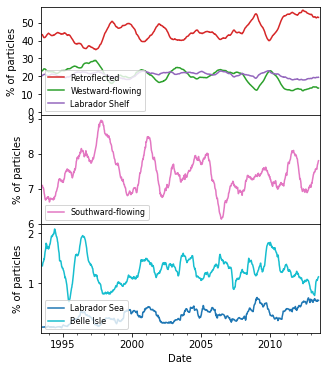

In [81]:
# plot normalized time series

import matplotlib.dates as mdates

f, (ax1, ax2, ax3) = plt.subplots(3,1,figsize = (5, 6),sharex=True)
ax1.set_ylabel('% of particles')

rms = np.zeros((1062,len(Groupes)))

for i in [0, 1, 3]:

    tm,rm = running_mean(Dates_all, np.sum(n_labels_all[:,Groupes[i]], axis = 1), 52)
    rm = rm/966.*100. #rm = rm / np.mean(rm)
    ax1.plot(tm, rm, label = Names[i], color = Col[i])
    rms[:,i] = rm
ax1.legend(loc='lower left', fontsize=8)
    
for i in [4]:

    tm,rm = running_mean(Dates_all, np.sum(n_labels_all[:,Groupes[i]], axis = 1), 52)
    rm = rm/966.*100. #rm = rm / np.mean(rm)
    ax2.plot(tm, rm, label = Names[i], color = Col[i])
    rms[:,i] = rm
ax2.legend(loc='lower left', fontsize=8)
    
ax2.set_ylabel('% of particles')
ax3.set_ylabel('% of particles')
ax3.set_xlabel('Date')

for i in [2, 5]:
    
    tm,rm = running_mean(Dates_all, np.sum(n_labels_all[:,Groupes[i]], axis = 1), 52)
    rm = rm/966.*100. #rm = rm / np.mean(rm)
    ax3.plot(tm, rm, label = Names[i], color = Col[i])
    rms[:,i] = rm
ax3.legend(loc='lower left', fontsize=8)

ax3.set_xlim([Dates_all[20], Dates_all[-21]])
ax1.set_ylim([-2,59])
ax1.yaxis.set_major_locator(plt.MultipleLocator(10))
ax2.yaxis.set_major_locator(plt.MultipleLocator(1))
ax3.yaxis.set_major_locator(plt.MultipleLocator(1))
ax1.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.xaxis.set_minor_locator(mdates.YearLocator(base=1))

plt.subplots_adjust(hspace=0)
#ax.legend()
plt.savefig(path_figs+'time_series.png',dpi=300)
plt.show()


## Spectral analysis

In [59]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.fftpack import fft
from scipy.fft import fft, fftfreq
from scipy.stats import norm
from scipy import signal
from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit
import math
from numpy.fft import irfft, rfftfreq

#------------------------------------------------------------
def broken_conf(x,step_len, *args, **kwargs):
	
	"""
	Generate confidence intervals for a signal containing white and 
	colored noise.
    Based on the algorithm in:
    S. Vaughan: 
    "A simple test for periodic signals in red noise" (2005)
    10.1051/0004-6361:20041453 
    Parameters:
    -----------
    x : float.
        The input signal. 
        Needs to be evenly spaced in time. 
        1-dimensional array. 
        Labelling assumes the signal to be on the scale of days, but can 
        have any units. 
    step_len : integer.
        Cadence of the input signal. 
        Need to implement a non-integer
        cadence in future. For now, only input integers. 
    P : float, optional.
        Probability wanted from confidence level.
        Should range from 0-1; i.e P = 0.85 is an 85% significance. 
        Default level is 0.95 (95%).
    show: bool,
		If 'True', returns a figure with the input signal, 
		power distribution of the periodogram, power against frequency,
		power against period, Nyquist freq, and associated 
		confidence level.
		The fit is given by a solid red line, and the confidence level 
		is given as a dashed red line. 
		If 'False', produces no illustrative output. 
    
    Returns
    -------
    out : array, array, array, float
         f				 The frequency array from the periodogram
         power_sig  	 The power array from the periodogram
         fit_model_ci 	 The fitted confidence interval array
         output_per 	 The largest period which exceeds the confidence
						 level
         
    Issues to be resolved:
    ---------
	If multiple peaks exceed the confidence level, output_per 
	automatically selects the largest periodicity of the set, rather the
	one which exceeds the confidence level by the greatest amount. 
         
    Example:
    ---------
    # Find the (most) significant peak in an input signal at a 95% 
    # confidence level.
    # Input signal is an array x, with cadence of 5 units. 
    
    >>> from conf_finder import broken_conf
    >>> broken_conf(x,5,P=0.95, show=True )
    
    Created 25th August 2019 by Tishtrya Mehta
    """
    
    
	sig_input=x
	step=step_len
	P=kwargs.get('P', None)
	show= kwargs.get('show', None)
	freq_max=[]	
	t=np.linspace(0, len(sig_input)*step, num=len(sig_input))
	t_hist=np.linspace(0,9,9000)										# NEED A SEPARATE TIME ARRAY FOR CADENCE ON HISTOGRAM
	if P == None:														# SET A CONFIDENCE LEVEL (DEFAULT 95)
		P=0.95
	if P>1.:
		print('The input confidence level should be between 0 and 1.0. For example, for a 99% level input: "P=0.99"')
		quit()							
	#-------------------------------------------------------------
	# COMPUTATION

	# CREATE SCIPY PERIODOGRAM
	f, power_sig = signal.periodogram(sig_input, fs=1./step, scaling='spectrum')
	power_sig=power_sig[0:int(len(sig_input)/2)]						# DISCARD THE NEGATIVE FREQUENCIES
	f=f[0:int(len(sig_input)/2)]
	#power_sig= power_sig/np.mean(power_sig)							# UNCOMMENT TO NORMALISE THE MEAN POWER TO EQUAL 1.

	# CREATE FITTING						
	f_log,power_log = zip(*[(math.log10(n), math.log10(g)) for n,g in zip(f, power_sig) if n>0.]) # DISCARD THE FIRST FREQUENCY (NYQUIST) AND ANY NEGATIVE VALUES

	# FIT THE POWER SPECTRA IN LINSPACE (SEE NOTES FOR LOGIC)
	# (SURPRESSES BIAS FOR THE LEAST SQUARE FITTING FOR THE LARGEST VALUES)
	def linbreak(x,m,C1,C2):
		return np.piecewise(x,[x<(C1-C2)/m,x>=(C1-C2)/m],[lambda x: C1 - m*x,C2])
		
	popt,pcov= curve_fit( linbreak, f_log, power_log, p0=[3.5,1.5,-0.5])# INITIAL GUESSES ARE BASED ON SIMULATED DATA
	fit_model_log=linbreak(f_log, *popt)								# I DONT KNOW WHAT POPT ACTUALLY MEANS, BUT I LIKE THE WORD. POPT! POP! POPT!
	fit_model=[ 10.**(n) for n in fit_model_log]						# MOVE MODEL BACK TO 'LOG' SCALES
	f=list([10.**(n) for n in f_log])							
	power_sig=[10.**(n) for n in power_log]
	
	nf= (len(sig_input))/2.	
	# FIND CONFIDENCE LEVELS
	ci= -2.*np.log(1.-(P)**(1/nf)) 										# USING P=1. -(1-np.exp(-x/2))**N. (SEE PAGE 6 OF VAUGHAN 2005 OR NOTES)
	
	#---------------------------------------------------------------------------------------------------------------------------------------------------
	# IMPORTANT! HERE WE USE A CONF. LEVEL FOR A CHI-SQR 2 DOF DISTRIBUTION. THIS IS NOT NECESSAIRILY THE DISTRIBUTION OF AN ARTIFICIAL INPUT SIGNAL.
	# THIS IS THE ASSUMPTION WE TEST AGAINST TO ESTIMATE THE SIGNIFICANCE OF PEAKS AGAINST THE NULL HYPOTHESIS
	#---------------------------------------------------------------------------------------------------------------------------------------------------
	
	fit_model_ci=[i*ci*0.5 for i in fit_model]							# THE CI IS CALCULATED FOR A CHI-SQR 2 DOF DISTRIBUTION (WHICH HAS A MEAN OF 2). TO APPLY
																		# THE CI TO OUR DISTRIBUTION, WE MUST RENORMALISE SUCH THAT MEAN =1 (WHICH IS THE 0.5 FACTOR) 
																		# THEN MULTIPLY BY YFIT. SEE YOUR NOTES ( OR REREAD VAUGHAN OR PUGH 2017 (SEE BELOW) ) 
										
	for n in range(len(fit_model_ci)):									# COLLECT THE ARRAY OF POINTS WHICH HAVE POWER > CI. 
		if power_sig[n]> fit_model_ci[n]:
			freq_max.append(1./f[power_sig.index(power_sig[n])])

	return f, power_sig, fit_model, fit_model_ci#, output_per 

/aos/home/mathilde/miniconda3/envs/Mython3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


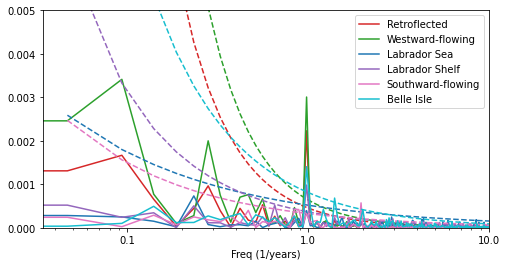

In [60]:
import matplotlib.ticker as mticker

f, ax = plt.subplots(1,1,figsize=(8,4))
for n in range(len(Groupes)):
        
    norm = raw[n]/max(raw[n]) # normalize
        
    #yf = fft(norm)
    #xf = fftfreq(len(raw[n]), 1./52.) # in years
    xf, yf = signal.periodogram(norm, fs=52., scaling='spectrum')

    med = int(len(xf)/2.)
    plt.semilogx(xf[:med], np.abs(yf)[:med], c=Col[n], label=Names[n])
    
    # compare with noise
    # https://github.com/TaraAthem/Confidence_Levels/blob/master/conf_finder_example.py
    f, power_sig, fit_model, fit_model_ci  = broken_conf( norm, 1./52., P=0.95, show=False )
    #plt.semilogx(f, fit_model)
    plt.semilogx(f, fit_model_ci, '--', c=Col[n])
    
plt.xlim([0,10]) ; plt.ylim([0,0.005])
plt.xlabel('Freq (1/years)')
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
#plt.yscale('log')
plt.legend()
#plt.title('Power spectrum')
plt.savefig(path_figs+'Spectrum.png',dpi=300)
plt.show()

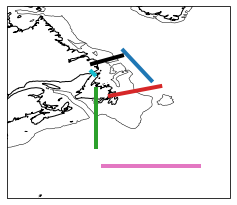

In [67]:
# Plot map of the sections

loc_propag = {'Retroflected':[-53.9, -46, 48, 49.5], 'Westward-flowing':[-56., -56., 40., 49.], 'Westward, then retroflected':[-54.2, -54.2, 40, 47.4], 'Southward-flowing':[-55, -40, 37, 37], 'Labrador Sea':[-47.4, -51.8, 50.4, 55.1], 'Labrador Shelf':[0,0,0,0], 'Belle Isle':[-56.3, -56.8, 51.3, 51.8]}

# Load data from Glorys reanalysis
f = '/storage3/shared/Glorys12/GLO-MFC_001_030_mask_bathy.nc'
ds = xr.open_dataset(f)
ds = ds.sel(latitude=slice(32,62), longitude=slice(-75,-30))
grid_z = ds.deptho

f = plt.figure(figsize=(4,4))
ax = f.add_subplot(1,1,1,projection=ccrs.PlateCarree())
ax.set_extent([-70,-35,32,62], crs=ccrs.PlateCarree())
ax.coastlines()

cs = grid_z.plot.contour(ax=ax, transform=ccrs.PlateCarree(), levels=[350], colors='k', linewidths=0.5)

c=0
for name in Names:
    loc = loc_propag[name]
    ax.plot([loc[0],loc[1]], [loc[2],loc[3]], color=Col[c], lw=4, transform=ccrs.PlateCarree())
    c+=1
    
ax.plot([-56.7,-52],[53,54.3], 'k', lw=4, transform=ccrs.PlateCarree())

plt.savefig(path_figs+'map_export_zones.png',dpi=300)
plt.show()


In [68]:
# first gather pathway categories
cross_time_groups = [[] for i in range(len(Groupes))]
cross_date_groups = [[] for i in range(len(Groupes))]
for n in range(len(cross_time)):
    
    for g in range(len(Groupes)):
        if n in Groupes[g]:
            idx = g
            break
            
    cross_time_groups[g].extend( cross_month[n] )
    cross_date_groups[g].extend( cross_time[n] )

# then get the seasonal cycle for each    
s_cycle = []
for n in range(len(cross_time_groups)):
    hist, bin_edges = np.histogram( cross_time_groups[n], bins=12 )
    mn = np.mean(hist)
    s_cycle.append( hist/mn )


/aos/home/mathilde/miniconda3/envs/Mython3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


## Seasonal cycle per year

In [70]:
# then take one category and split per year

yrs = range(1993,2016)

cycle = [[] for i in range(len(cross_time_groups))]
cycle_tot = [[] for i in range(len(cross_time_groups))]
for j in range(len(cross_time_groups)):
    
    per_years = [[] for i in range(len(yrs))]
    for i in range(len(cross_time_groups[j])):
        yr = int(cross_date_groups[j][i])
        idx = yrs.index( yr )
        per_years[idx].append( cross_time_groups[j][i] )
        
    # get the seasonal cycle for each year
    for i in range(len(per_years)):
        hist, bin_edges = np.histogram( per_years[i], bins=12 )
        mn = np.mean(hist)
        cycle[j].append( hist/mn )
    
    # check if total fits with what I had before, to make sure that the calculations are right
    hist, bin_edges = np.histogram( [item for sublist in per_years for item in sublist], bins=12 )
    cycle_tot[j] = (hist-np.mean(hist))/np.mean(hist)

/aos/home/mathilde/miniconda3/envs/Mython3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/aos/home/mathilde/miniconda3/envs/Mython3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


In [71]:
# Use this to calculate the uncertainty on the seasonal cycle
std_up = [] ; std_down = []
for n in range(len(cycle)):
    data = np.array(cycle[n])
    
    # get the above and below standard deviations
    dev_up = [] ; dev_down = []
    for j in range(data.shape[1]) : # for each month
        dev_up_l = 0 ; dev_down_l = 0 ; cu = 0; cd = 0
        for i in range(data.shape[0]) : # for each year
            if data[i][j] > s_cycle[n][j] :
                dev_up_l += (data[i][j] - s_cycle[n][j])**2
                cu+=1
            else:
                dev_down_l += (data[i][j] - s_cycle[n][j])**2
                cd+=1
        try:
            dev_up.append( np.sqrt(dev_up_l/cu)/2 )
        except:
            dev_up.append(0)
        try:
            dev_down.append( np.sqrt(dev_down_l/cd)/2 )
        except:
            dev_down.append(0)
        
    std_up.append( dev_up )
    std_down.append( dev_down )

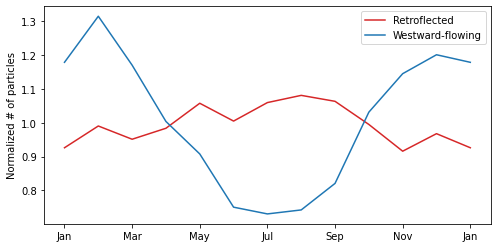

In [75]:
# load crossing time

cross_time_seesaw = [[] for i in range(2)]
cross_date_seesaw = [[] for i in range(2)]
for yr in range(1993,2014):
    ds = np.genfromtxt(path_clusters+'Crossing_dates/crossing_dates_seesaw_%04d.csv'%yr, delimiter=',')
    for i in range(2):
        dum = ds[:,i]
        cross_date_seesaw[i].extend( [each for each in dum if each!= 0] )
        cross_time_seesaw[i].extend( [each-int(each) for each in dum if each!= 0] )
   
# then get the seasonal cycle for each    
s_cycle_seesaw = []
for n in range(len(cross_time_seesaw)):
    hist, bin_edges = np.histogram( cross_time_seesaw[n], bins=12 )
    mn = np.mean(hist)
    s_cycle_seesaw.append( list(hist/mn) )
    s_cycle_seesaw[n].append( s_cycle_seesaw[n][0] )

In [76]:
# Check per year also

# then take one category and split per year

yrs = range(1993,2016)

cycle_ss = [[] for i in range(len(cross_time_seesaw))]
cycle_ss_tot = [[] for i in range(len(cross_time_seesaw))]
for j in range(len(cross_time_seesaw)):
    
    per_years = [[] for i in range(len(yrs))]
    for i in range(len(cross_time_seesaw[j])):
        yr = int(cross_date_seesaw[j][i])
        idx = yrs.index( yr )
        per_years[idx].append( cross_time_seesaw[j][i] )
        
    # get the seasonal cycle for each year
    for i in range(len(per_years)):
        hist, bin_edges = np.histogram( per_years[i], bins=12 )
        mn = np.mean(hist)
        cycle_ss[j].append( hist/mn )
    
    # check if total fits with what I had before, to make sure that the calculations are right
    hist, bin_edges = np.histogram( [item for sublist in per_years for item in sublist], bins=12 )
    cycle_ss_tot[j] = hist/np.mean(hist)
    
# Use this to calculate the uncertainty on the seasonal cycle
std_up_ss = [] ; std_down_ss = []
for n in range(len(cycle_ss)):
    data = np.array(cycle_ss[n])
    
    # get the above and below standard deviations
    dev_up = [] ; dev_down = []
    for j in range(data.shape[1]) : # for each month
        dev_up_l = 0 ; dev_down_l = 0 ; cu = 0; cd = 0
        for i in range(data.shape[0]) : # for each year
            if data[i][j] > s_cycle[n][j] :
                dev_up_l += (data[i][j] - cycle_ss_tot[n][j])**2
                cu+=1
            else:
                dev_down_l += (data[i][j] - cycle_ss_tot[n][j])**2
                cd+=1
        try:
            dev_up.append( np.sqrt(dev_up_l/cu)/2 )
        except:
            dev_up.append(0)
        try:
            dev_down.append( np.sqrt(dev_down_l/cd)/2 )
        except:
            dev_down.append(0)
        
    std_up_ss.append( dev_up )
    std_down_ss.append( dev_down )


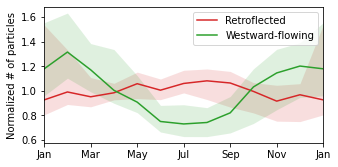

In [78]:
# plot seasonal cycle with the uncertainty 

f, ax = plt.subplots(1,1,figsize = (5, 2.5))
ax.set_ylabel('Normalized # of particles')
names_seesaw = ['Retroflected', 'Westward-flowing'] ; col_seesaw = [Col[0], Col[1]]

for i in range(2):
    lcycle = list(s_cycle_seesaw[i]) ; lstd_up = std_up_ss[i] ; lstd_down = std_down_ss[i]
    lstd_up.append(lstd_up[0]) ; lstd_down.append(lstd_down[0])
    ax.plot(np.arange(1,14), lcycle, label = names_seesaw[i], color = col_seesaw[i])
    ax.fill_between(np.arange(1,14), [lcycle[j]-lstd_down[j] for j in range(len(lcycle))], [lcycle[j]+lstd_up[j] for j in range(len(lcycle))], color=col_seesaw[i], alpha=0.15, lw=0)

ax.legend()
plt.xticks([1,3,5,7,9,11,13], ['Jan', 'Mar', 'May', 'Jul', 'Sep', 'Nov', 'Jan'])
plt.xlim([1,13])

plt.savefig(path_figs+'seesaw_seasonal_cycle.png',dpi=300)
plt.show()